### part0:imports

In [2]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        defs = params.random_walk_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'random_walk')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')

import warnings
warnings.filterwarnings("ignore")

Done


### Get data

In [9]:
def get_full_random_walk_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList['MCx'].items():
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    allDFs_reaches_MCx = []
    for animal, session in full_list_MCx:
        path = root/'random_walk'/animal/session
        df_ = defs.prep_general(dt.load_pyal_data(path))
        allDFs_MCx.append(df_)

        #separate into reaches
        df_ = defs.get_reaches_df(df_)

        #execution epoch
        for col in df_.columns:  #TODO: placeholder to prevent bug in pyaldata
            if 'unit_guide' in col:
                df_ = df_.drop([col], axis = 1)
        df_ = pyal.add_movement_onset(df_)
        df_ = pyal.restrict_to_interval(df_, epoch_fun=defs.exec_epoch)

        #subset center-out trials
        df_ = df_[df_.dist_start_center < defs.subset_radius]
        df_ = df_.reset_index()
        allDFs_reaches_MCx.append(df_)
        
    return full_list_MCx, allDFs_MCx, allDFs_reaches_MCx

In [10]:
MCx_list, allDFs_MCx, allDFs_reaches_MCx = get_full_random_walk_data()

In [14]:
ref_file = 'Chewie_RT_CS_2016-10-21.mat'
ref_i = [y for x,y in MCx_list].index(ref_file)

ex_file = 'Mihili_RT_VR_2014-01-15.mat'
ex_i = [y for x,y in MCx_list].index(ex_file)

df1 = allDFs_reaches_MCx[ref_i]
df2 = allDFs_reaches_MCx[ex_i]


#### perform pca

In [15]:
rates = np.concatenate(df1['MCx_rates'].values, axis=0)
rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
df1 = pyal.apply_dim_reduce_model(df1, rates_model, 'MCx_rates', '_pca');

rates = np.concatenate(df2['MCx_rates'].values, axis=0)
rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
df2 = pyal.apply_dim_reduce_model(df2, rates_model, 'MCx_rates', '_pca');

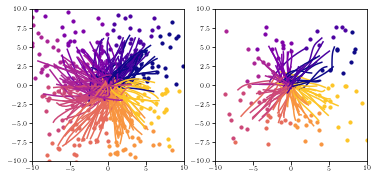

In [18]:
#plot centered reaches for each dataset
colors = utility.get_colors(defs.n_target_groups)
fig, axs = plt.subplots(ncols=2)
for j, df_ in enumerate([df1,df2]):
    for i in range(len(df_)):
        pos = df_.pos_centered.values[i]
        targets = df_.target_centered.values[i]
        target_group = df_.target_group.values[i]
        axs[j].plot(*pos[:].T, c=colors[target_group])
        axs[j].scatter(*targets[:].T, s = 10, c=colors[target_group])
    axs[j].set_aspect(1)
    axs[j].set_xlim([-10,10])
    axs[j].set_ylim([-10,10])

In [19]:
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

#match movements
print('Ntrials:', len(df1), len(df2))

#match by target
df1_targets = np.vstack(df1.target_centered)
df2_targets = np.vstack(df2.target_centered)
distances = cdist(df1_targets,df2_targets,metric = 'euclidean')
print(df1_targets.shape, df2_targets.shape, distances.shape)
# fig, ax = plt.subplots()
# ax.imshow(distances)
closest_dist = np.min(distances.T, axis = 1)
closest_targets = np.argmin(distances.T, axis = 1)

# plt.figure()
# plt.hist((closest_dist).flatten(), color = 'b', histtype='step')
# plt.hist((distances).flatten(), color = 'r', histtype='step')
# df1_pos = np.vstack(df1.pos_centered)
# df2_pos = np.vstack(df2.pos_centered)

# match by pos corr or mse
corrs = np.zeros([len(df1), len(df2)])
mses = np.zeros([len(df1), len(df2)])
for i, pos1 in enumerate(df1.pos_centered):
    for j, pos2 in enumerate(df2.pos_centered):
        # if j<i: continue
        r = [pearsonr(aa,bb)[0] for aa,bb in zip(pos1.T,pos2.T)]
        mse = np.mean((pos1-pos2)**2)
        corrs[i][j] = np.mean(r)
        mses[i][j] = mse
        # corrs[j][i] = np.mean(np.abs(r))
max_corrs = np.max(corrs.T, axis = 1)
closest_corr = np.argmax(corrs.T, axis = 1)

min_mses = np.min(mses.T, axis = 1)
closest_pos = np.argmin(mses.T, axis = 1)
# df1_pos = np.vstack(df1.pos_centered)
# df2_pos = np.vstack(df2.pos_centered)
# df1_pos.shape
# df1_targets.shape

Ntrials: 233 93
(233, 2) (93, 2) (233, 93)


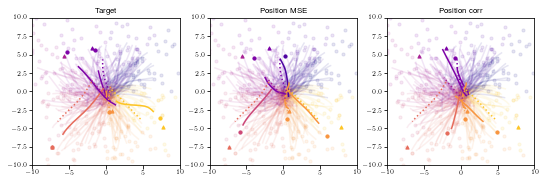

In [28]:
criteria = [closest_targets, closest_pos, closest_corr]
col_names = ['Target', 'Position MSE', 'Position corr']

fig,axs = plt.subplots(ncols=len(criteria), figsize = (3*len(criteria), 3))
colors = utility.get_colors(defs.n_target_groups)
ntrials = 5

for j, crit in enumerate(criteria):
    df = df1
    for i in range(len(df)):
        pos = df.pos_centered.values[i]
        targets = df.target_centered.values[i]
        target_group = df.target_group.values[i]
        axs[j].plot(*pos[:].T, c=colors[target_group], alpha = 0.1)
        axs[j].scatter(*targets[:].T, s = 10, c=colors[target_group], alpha = 0.1)

    df = df1.iloc[crit]
    for i in range(ntrials):
        pos = df.pos_centered.values[i]
        targets = df.target_centered.values[i]
        target_group = df.target_group.values[i]
        axs[j].plot(*pos[:].T, c=colors[target_group])
        axs[j].scatter(*targets[:].T, s = 10, c=colors[target_group])

    df = df2
    for i in range(ntrials):
        pos = df.pos_centered.values[i]
        targets = df.target_centered.values[i]
        target_group = df.target_group.values[i]
        axs[j].plot(*pos[:].T, c=colors[target_group], linestyle = 'dotted')
        axs[j].scatter(*targets[:].T, s = 10, c=colors[target_group],marker = '^')
    axs[j].set_aspect(1)
    axs[j].set_xlim([-10,10])
    axs[j].set_ylim([-10,10])

for i in range(len(col_names)):
    axs[i].set_title(col_names[i])

In [22]:
import collections
for crit in criteria:
    print([(item,count) for item, count in collections.Counter(crit).items() if count > 1])

print(collections.Counter(df1.target_group))
print(collections.Counter(df2.target_group))

#separate into groups


#upper bound: within session, trials that are next to each other

#actual reaches: best if they are evenly spaced around the center? 

[(90, 2), (208, 2), (79, 2), (23, 2), (136, 2), (183, 2), (60, 2), (223, 2), (200, 3), (29, 2), (192, 2), (38, 2), (164, 2), (20, 2), (35, 2), (41, 2)]
[(175, 3), (188, 3), (87, 2), (5, 2), (127, 3), (106, 2), (214, 4), (118, 2), (88, 2), (48, 2), (152, 3), (74, 4), (95, 2), (193, 2), (81, 3), (4, 2), (221, 3), (22, 2), (200, 3), (31, 2)]
[(36, 4), (84, 4), (152, 2), (18, 2), (185, 4), (2, 2), (173, 2), (132, 2), (145, 2), (116, 3), (47, 2), (223, 2), (16, 2), (221, 5), (60, 3), (187, 3), (190, 2), (130, 2), (74, 2), (14, 2)]
Counter({3: 34, 5: 33, 0: 31, 6: 31, 1: 28, 2: 27, 4: 25, 7: 24})
Counter({7: 17, 6: 14, 4: 14, 2: 13, 5: 10, 0: 9, 3: 8, 1: 8})


In [30]:
# match by pos corr or mse
corrs = np.zeros([len(df1), len(df2)])
mses = np.zeros([len(df1), len(df2)])
for i, pos1 in enumerate(df1.pos_centered):
    for j, pos2 in enumerate(df2.pos_centered):
        # if j<i: continue
        r = [pearsonr(aa,bb)[0] for aa,bb in zip(pos1.T,pos2.T)]
        mse = np.mean((pos1-pos2)**2)
        corrs[i][j] = np.mean(r)
        mses[i][j] = mse
        # corrs[j][i] = np.mean(np.abs(r))
max_corrs = np.max(corrs.T, axis = 1)
closest_corr = np.argmax(corrs.T, axis = 1)

min_mses = np.min(mses.T, axis = 1)
closest_pos = np.argmin(mses.T, axis = 1)

print([(item,count) for item, count in collections.Counter(closest_pos).items() if count > 1])


[(175, 3), (188, 3), (87, 2), (5, 2), (127, 3), (106, 2), (214, 4), (118, 2), (88, 2), (48, 2), (152, 3), (74, 4), (95, 2), (193, 2), (81, 3), (4, 2), (221, 3), (22, 2), (200, 3), (31, 2)]


97
32


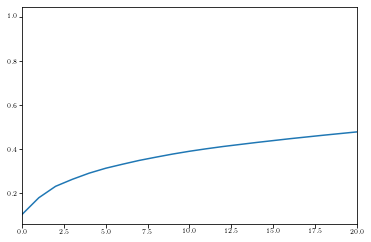

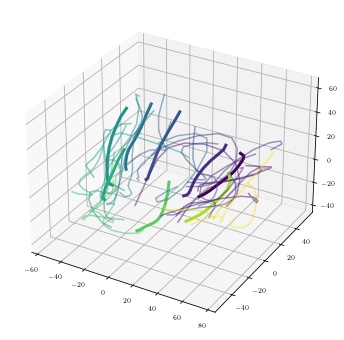

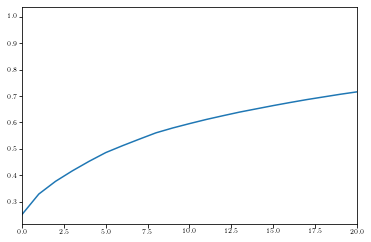

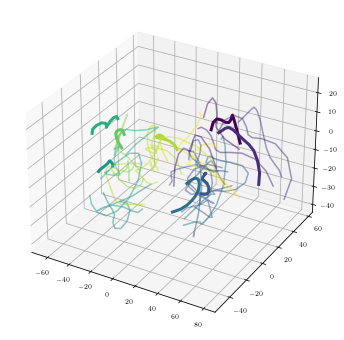

In [24]:
# %matplotlib widget
%matplotlib inline
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, 360)
for df_ in [df1,df2]:
    #check dimensionality
    model = pyal.fit_dim_reduce_model(df_, PCA(), 'MCx_rates')
    dim = (np.nonzero((np.cumsum(model.explained_variance_ratio_) > 0.8))[0][0])
    print(dim)

    plt.figure()
    plt.plot(np.cumsum(model.explained_variance_ratio_))
    plt.xlim([0,20])

    # plot PCA
    colors = utility.get_colors(8, 'viridis')
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(projection = '3d')

    for tar in range(defs.n_target_groups):
        df__ = pyal.select_trials(df_, df_.target_group==tar)
        ex = pyal.get_sig_by_trial(df__,'_pca')
        ex = np.mean(ex, axis=2)[:,:3]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=3)
        # ax.view_init(60,-47)

    # for i in range(len(df_)):
    for i in range(30):
        pca = df_._pca.values[i]
        angle = df_.target_angle.values[i]
        ax.plot(pca[:,0],pca[:,1],pca[:,2],c=cmap(norm(angle)), alpha=0.5)


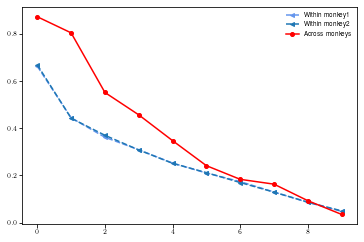

In [29]:
#cca

#CCs
data1 = np.concatenate(df1.iloc[closest_pos]._pca.values, axis = 0)
data2 = np.concatenate(df2._pca.values, axis = 0)
allCCs = np.array(dt.canoncorr(data1, data2))
allCCs = np.array(allCCs).T

CCsU = []
#upper bound
for df in [df1, df2]:
    n_shared_trial1 = len(df1)
    trialList1 = np.arange(n_shared_trial1)
    r = []
    for n in range(params.n_iter * 10):
        params.rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.concatenate(df1.iloc[trial1]._pca.values, axis = 0)
        data2 = np.concatenate(df1.iloc[trial2]._pca.values, axis = 0)
        r.append(dt.canoncorr(data1, data2))
    CCsU.append(r)
CCsU = np.array(CCsU)
CCsU = np.percentile(CCsU, 99, axis=1).T

# #lower bound
# for df in [df1, df2]:
#     n_shared_trial1 = len(df1)
#     trialList1 = np.arange(n_shared_trial1)
#     r = []
#     for n in range(params.n_iter * 10):
#         params.rng.shuffle(trialList1)
#         # non-overlapping randomised trials
#         trial1 = trialList1[:n_shared_trial1//2]
#         trial2 = trialList1[-(n_shared_trial1//2):]
#         data1 = np.concatenate(df1.iloc[trial1]._pca.values, axis = 0)
#         data2 = np.concatenate(df1.iloc[trial2]._pca.values, axis = 0)
#         r.append(dt.canoncorr(data1, data2))
#     CCsU.append(r)
# CCsU = np.array(CCsU)
# CCsU = np.percentile(CCsU, 99, axis=1).T

plt.figure()
# plt.plot(CCsU, c = 'r')

plt.plot(CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
plt.plot(CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
plt.plot(allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')

plt.legend()


In [146]:
data1.shape, data2.shape

((2796, 10), (1116, 10))